# Introdução

Este exercı́cio consiste avaliar o desempenho de um classificador na tarefa de reconhecer imagens de faces humanas. A avaliação deve ser feita através da taxa de acerto do classificador Bayesiano. A base de dados a ser utilizada será a de faces Olivetti, neste exercı́cio também será utilizada uma técnica de redução de dimensionalidade na base de dados, o PCA, apresentado em sala de aula.


# Base de Faces Olivetti

Este conjunto de dados contém um conjunto de imagens faciais obtidas entre abril de 1992 e abril de 1994 na AT&T Laboratories Cambridge. A função sklearn.datasets.fetch_olivetti_faces [1] é a função de busca / armazenamento de dados que baixa o arquivo de dados da AT&T. A base de dados disponível por esta função consiste em imagens de 64x64 pixels. 

Neste dataset existem dez imagens diferentes de cada um dos 40 sujeitos distintos. Para alguns sujeitos, as imagens foram tiradas em momentos diferentes, variando a iluminação, expressões faciais (olhos abertos / fechados, sorrindo / não sorrindo) e detalhes faciais (óculos / sem óculos). Todas as imagens foram tiradas contra um fundo escuro homogêneo com os assuntos em uma posição frontal vertical (com tolerância para alguns movimentos laterais) [2]. 

# Carregando Dataset

In [25]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from numpy.random import RandomState
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns

In [127]:
faces = fetch_olivetti_faces()
data = pd.DataFrame(data= np.c_[faces['data'], faces['target']])
data.shape

(400, 4097)

# Visualização de Faces

In [3]:
def plot_faces(title, images, n_col=5, n_row=2, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(comp.reshape(image_shape), cmap=cmap)
        plt.xticks(())
        plt.yticks(())

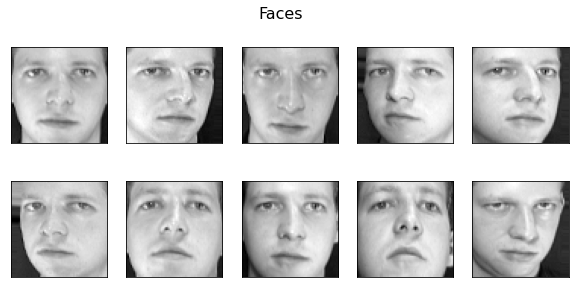

In [4]:
n_samples, n_features = data.shape
images = data.to_numpy().reshape(n_samples, -1)
image_shape = (64, 64)
plot_faces("Faces", images[:10, 0:-1])

# Redução de Dimensionalidade - PCA

Inicialmente, apenas para verificar a função PCA do pacote sklearn, a mesma será aplicada ao dataset para gerar imagens com apenas 3 features. Ou seja reduziu-se de 4096 features (64x64) para apenas 3. 

In [23]:
pca = PCA(n_components=3)
pca.fit(images[:,0:-1])
X = pca.transform(images[:,0:-1])
print(X.shape)

(400, 3)


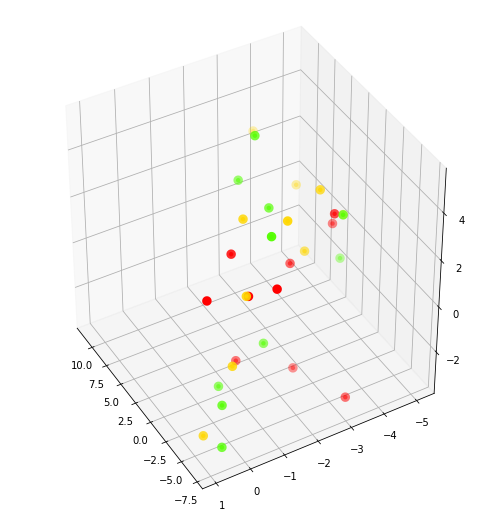

In [126]:
fig = plt.figure(1, figsize=(7, 7))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=38,azim=150)
plt.cla()

y = images[0:30,-1]
colors = ["green", "red", "blue"]
ax.scatter(X[0:10, :], X[10:20, :], X[20:30, :], c=y, cmap=plt.cm.prism, linewidths=5)

plt.show()


# Classificador Bayesiano Gaussiano Multivariado

Abaixo se encontra o código do Classificador Bayesiano Gaussiano Multivariado desenvolvido nas últimas listas.

In [7]:
# Bayes Classifier 
class bayes_classifier:

    # To initialize the parameters from the Bayes algorithm:
    def __init__(self):
        self.p_ci = None
        self.X_train = None
        self.y_train = None
        
    # Training the model
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        # Calculate P[C1], P[C2], ... , P[Cn]:
        n = np.unique(y).shape[0]
        self.p_ci =  np.zeros(n)
        for i in range(0,n):
            n_elements = np.count_nonzero(self.y_train==np.unique(self.y_train)[i])
            total_elements = self.y_train.shape[0]
            self.p_ci[i] = n_elements/total_elements
    
    def predict(self, X):
        # Calculate PDFs:
        n = np.unique(self.y_train).shape[0]
        mean_ci = np.zeros(self.X_train.shape[1])
        pdf = np.zeros(n)
        K = np.zeros(n)
        y = np.zeros(X.shape[0])
        index = 0; 
        for x in X:
            for i in range(0,n):
                indexes = np.where(self.y_train==np.unique(self.y_train)[i])
                for col in range(0, self.X_train.shape[1]):
                    mean_ci[col] = np.mean(self.X_train[indexes,col])       
                cov = np.cov(self.X_train, rowvar=False)
                pdf[i] = multivariate_normal.pdf(x, mean_ci, cov,allow_singular=True)
                K[i] = pdf[i] * self.p_ci[i]
            
            y[index] = K.argmax()
            index += 1
        return y

# Aplicação do PCA e do Classificador 

In [8]:
acc = np.zeros(10)
n_features = 100
features_selected = [2, 5, 10, 20, 30, 40, 50, 100]
stratified_array = np.zeros(400)
index = 0
value = 10
label = 0
while label < 40:
    for i in range(index, value):
        stratified_array[i] = label
        index += 1
    label += 1
    value += 10
    
for n_features in features_selected:
    for i in range(10):
        # Separate data between training and test:
        X_train, X_test, y_train, y_test = train_test_split(images[:,0:-1], images[:, -1], test_size=0.5, stratify=stratified_array)
        pca = PCA(n_components=n_features)
        pca.fit(X_train)
        PCs = pca.transform(X_train)
        clf = bayes_classifier()
        clf.fit(PCs[:, 0:n_features], y_train)
        X = pca.transform(X_test)
        y_pred = clf.predict(X[:, 0:n_features])
        acc[i] = accuracy_score(y_test, y_pred)
    print("\nAcurácia média para modelo considerando " + str(n_features) + " features: " + '{:.3f}'.format(acc.mean()) + " +/- " + '{:.3f}'.format(acc.std()))   


Acurácia média para modelo considerando 2 features: 0.164 +/- 0.014

Acurácia média para modelo considerando 5 features: 0.527 +/- 0.033

Acurácia média para modelo considerando 10 features: 0.740 +/- 0.038

Acurácia média para modelo considerando 20 features: 0.864 +/- 0.020

Acurácia média para modelo considerando 30 features: 0.865 +/- 0.024

Acurácia média para modelo considerando 40 features: 0.885 +/- 0.021

Acurácia média para modelo considerando 50 features: 0.893 +/- 0.018

Acurácia média para modelo considerando 100 features: 0.929 +/- 0.020


# Matriz de Confusão

Abaixo está mostrada a matriz de confusão para a aplicação do classificador ao problema reduzido à dimensionalidade de 40 features. Esse valor foi escolhido pois como visto anteriormente ele resulta em uma acurácia próxima a 90% e com um tempo razoável de execução.


Acc: 0.905


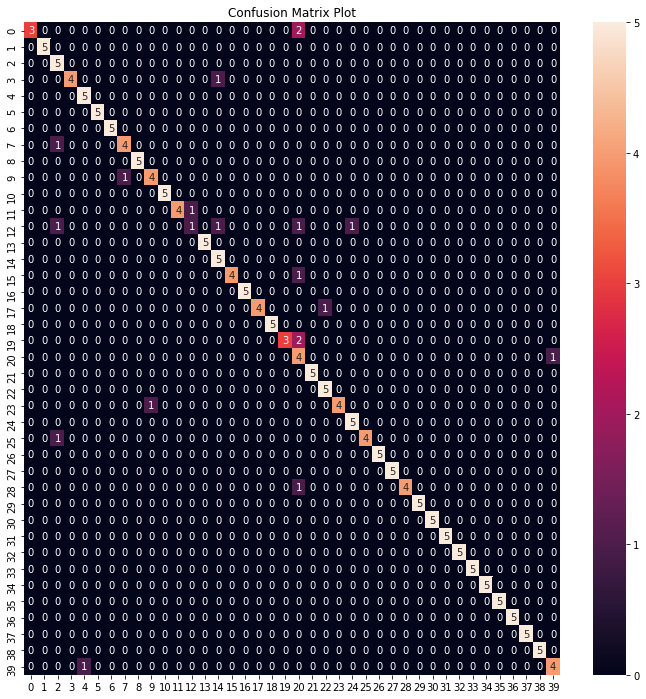

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images[:,0:-1], images[:, -1], test_size=0.5, stratify=stratified_array)
n_features = 40
pca = PCA(n_components=n_features)
PCs = pca.fit_transform(X_train)
clf = bayes_classifier()
clf.fit(PCs[:, 0:n_features], y_train)
X = pca.transform(X_test)
y_pred = clf.predict(X[:, 0:n_features])
df_confusion = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(df_confusion, annot=True, ax=ax)
plt.title('Confusion Matrix Plot')
    
#plot_confusion_matrix(df_confusion)
print("\nAcc: " + str(accuracy_score(y_test,y_pred)))

# Implementação do meu próprio PCA

In [10]:
class my_pca:

    # To initialize the parameters
    def __init__(self, n_features=None):
        self.n_components = n_features  
    
    # Training the model
    def fit(self, X):
        self.X_train = X
        # Average vector calculation 
        self.Xm = np.mean(self.X_train , axis = 0)
        #  X' <- X - Xm
        X_meaned = self.X_train - self.Xm
        # Covariance Matrix
        cov_mat = np.cov(X_meaned , rowvar = False)
        # Eigen Values and Eigen Vectors from Covariance Matrix 
        self.eigen_values, self.eigen_vectors = np.linalg.eigh(cov_mat)
        # Sorted lists:
        sorted_index = np.argsort(self.eigen_values)[::-1]
        sorted_eigenvalue = self.eigen_values[sorted_index]
        sorted_eigenvectors = self.eigen_vectors[:,sorted_index]
        # Truncate the number of components if dimensionality reduction is not None
        if self.n_components is not None:
            self.eigen_values = sorted_eigenvalue[0:self.n_components]
            self.eigen_vectors = sorted_eigenvectors[:, 0:self.n_components]
        return self
    
    def transform(self, X):
        X_new = X - self.Xm
        return X_new @ self.eigen_vectors
        


Acc: 0.905


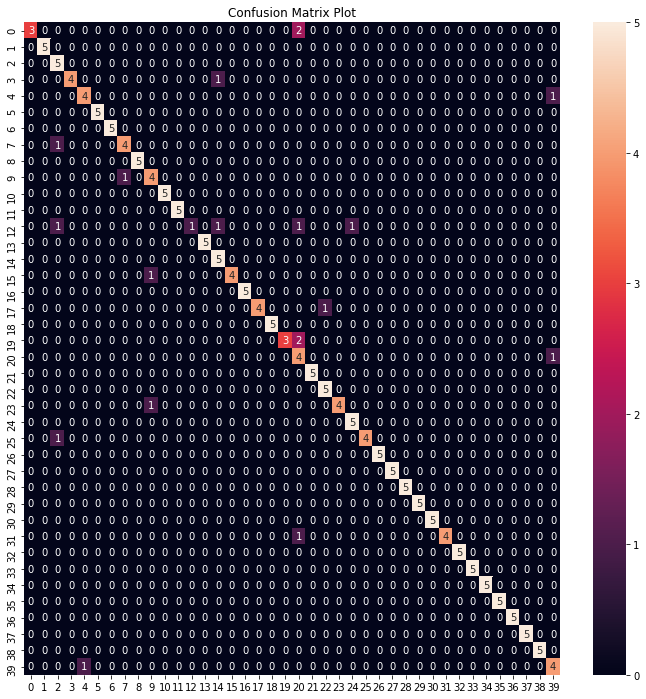

In [11]:
pca = my_pca(n_features=n_features)
pca.fit(X=X_train)
PCs = pca.transform(X_train)
clf = bayes_classifier()
clf.fit(PCs, y_train)
X = pca.transform(X_test)
y_pred = clf.predict(X)
df_confusion = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(df_confusion, annot=True, ax=ax)
plt.title('Confusion Matrix Plot')
    
#plot_confusion_matrix(df_confusion)
print("\nAcc: " + str(accuracy_score(y_test,y_pred)))

Como pode-se notar acima ao se utilizar o PCA desenvolvido obteve-se um resultado similar ao do sklearn.

# Referências

[1] API design for machine learning software: experiences from the scikit-learn project, Buitinck et al., 2013.

[2] Lars Buitinck, Gilles Louppe, Mathieu Blondel, Fabian Pedregosa, Andreas Mueller, Olivier Grisel, Vlad Niculae, Peter Prettenhofer, Alexandre Gramfort, Jaques Grobler, Robert Layton, Jake Vanderplas, Arnaud Joly, Brian Holt, & Gaël Varoquaux. (2013). API design for machine learning software: experiences from the scikit-learn project. 